In [2]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Настройка стиля
plt.style.use('default')
sns.set_palette("Set2")
sns.set_context("notebook", font_scale=1.1)

# Загрузка данных
target_xlsx = 'https://lms.skillfactory.ru/asset-v1:SkillFactory+MIFIML-2sem+2025+type@asset+block@%D0%94%D0%B0%D0%BD%D0%BD%D1%8B%D0%B5_%D0%B4%D0%BB%D1%8F_%D0%BA%D1%83%D1%80%D1%81%D0%BE%D0%B2%D0%BE%D0%B8__%D0%9A%D0%BB%D0%B0%D1%81%D1%81%D0%B8%D1%87%D0%B5%D1%81%D0%BA%D0%BE%D0%B5_%D0%9C%D0%9E.xlsx'
df = pd.read_excel(target_xlsx)

print("✅ Загрузка данных завершена. Размер датасета:", df.shape)

✅ Загрузка данных завершена. Размер датасета: (1001, 214)


In [3]:
# === Очистка данных ===
# Удаляем пустой столбец
df.drop(columns=['Unnamed: 0'], inplace=True, errors='ignore')

# Проверка пропусков
nan_cols = df.isnull().sum()
nan_cols = nan_cols[nan_cols > 0]

print(f"🔍 Найдено пропущенных значений: {nan_cols.sum()} в {len(nan_cols)} столбцах")
if len(nan_cols) > 0:
    print("Столбцы с пропусками:", list(nan_cols.index))

# Удаление строк с пропусками
initial_shape = df.shape[0]
df.dropna(inplace=True)
final_shape = df.shape[0]

print(f"🗑️ Удалено {initial_shape - final_shape} строк. Осталось: {final_shape}")

🔍 Найдено пропущенных значений: 36 в 12 столбцах
Столбцы с пропусками: ['MaxPartialCharge', 'MinPartialCharge', 'MaxAbsPartialCharge', 'MinAbsPartialCharge', 'BCUT2D_MWHI', 'BCUT2D_MWLOW', 'BCUT2D_CHGHI', 'BCUT2D_CHGLO', 'BCUT2D_LOGPHI', 'BCUT2D_LOGPLOW', 'BCUT2D_MRHI', 'BCUT2D_MRLOW']
🗑️ Удалено 3 строк. Осталось: 998


Вывод: Пропуски есть в 12 столбцах (по 3 значения). Это менее 0.3% — можно удалить. Очищённый датасет: 998 строк × 213 столбцов.

In [4]:
# === Биологическая интерпретация ===
med_ic50 = df['IC50, mM'].median()
med_cc50 = df['CC50, mM'].median()
med_si = df['SI'].median()

print(f"""
🎯 БИОЛОГИЧЕСКАЯ ИНТЕРПРЕТАЦИЯ ПОКАЗАТЕЛЕЙ:
IC50 (медиана: {med_ic50:.2f} mM) — чем ниже, тем эффективнее соединение.
CC50 (медиана: {med_cc50:.2f} mM) — чем выше, тем безопаснее.
SI = CC50 / IC50 (медиана: {med_si:.2f}) — индекс селективности.

🔹 SI > 8 — порог перспективных препаратов (FDA, EMA).
🔹 SI < 1 — токсичнее, чем эффективно — непригодно.
""")


🎯 БИОЛОГИЧЕСКАЯ ИНТЕРПРЕТАЦИЯ ПОКАЗАТЕЛЕЙ:
IC50 (медиана: 45.99 mM) — чем ниже, тем эффективнее соединение.
CC50 (медиана: 408.79 mM) — чем выше, тем безопаснее.
SI = CC50 / IC50 (медиана: 3.86) — индекс селективности.

🔹 SI > 8 — порог перспективных препаратов (FDA, EMA).
🔹 SI < 1 — токсичнее, чем эффективно — непригодно.



Вывод: Медианные значения показывают умеренную эффективность и токсичность. Ключевая цель — найти соединения с низким IC50, высоким CC50 и SI > 8. 

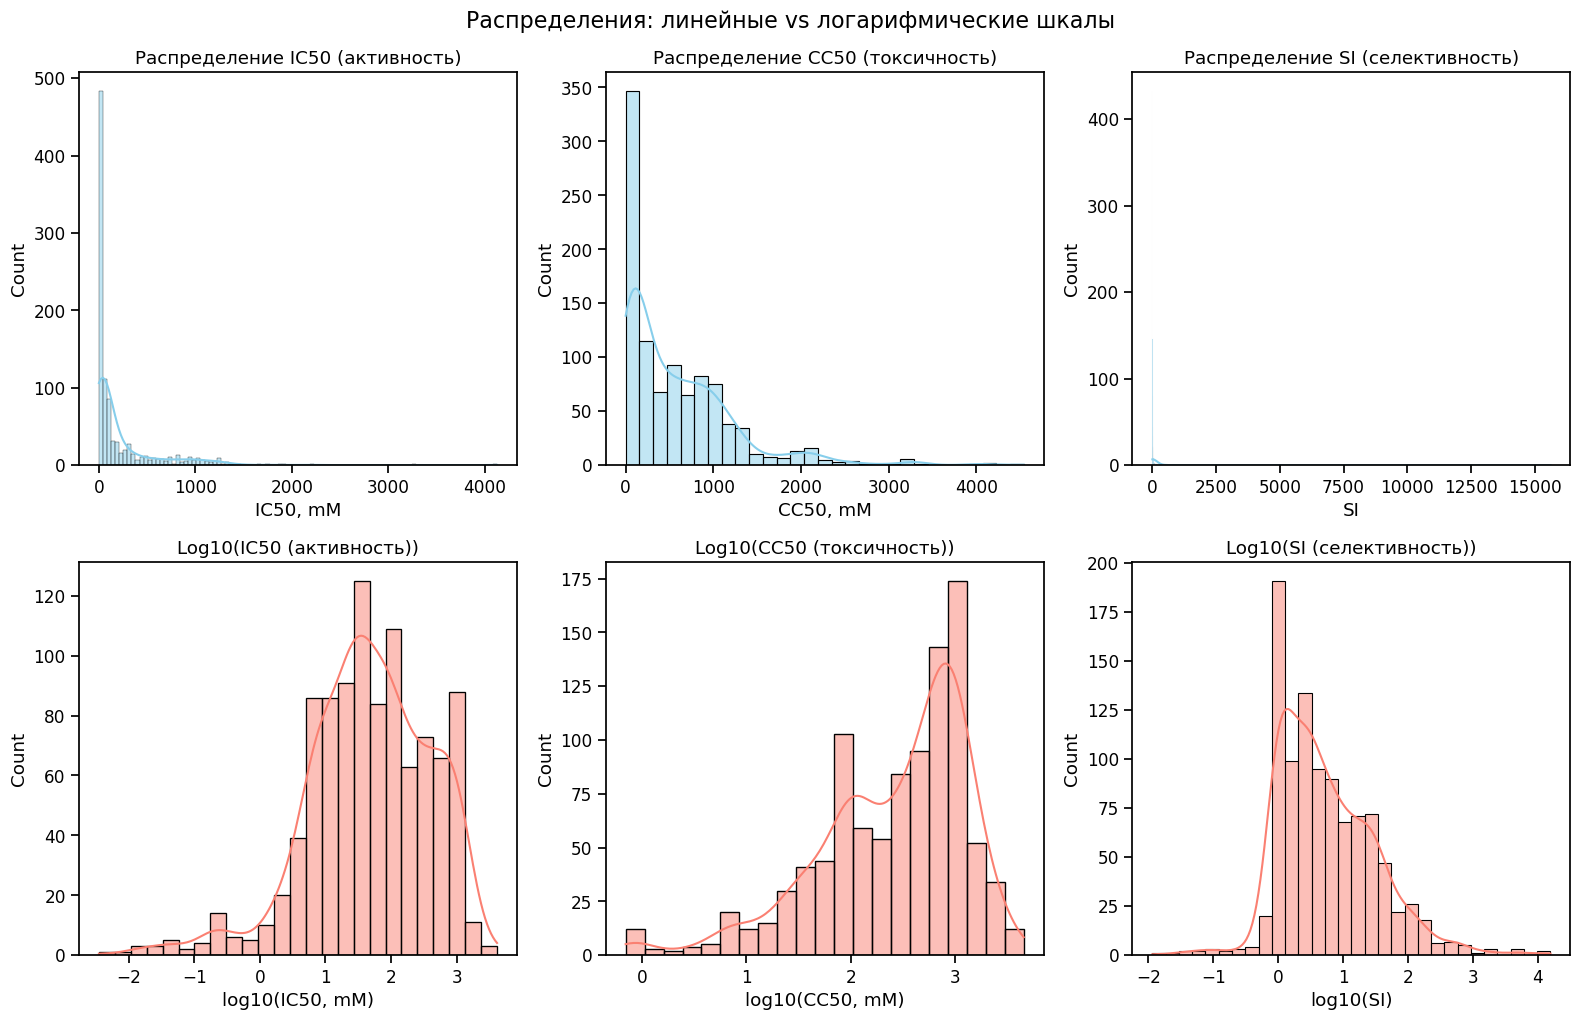

In [5]:
# === Распределения ===
fig, axes = plt.subplots(2, 3, figsize=(16, 10))
features = ['IC50, mM', 'CC50, mM', 'SI']
labels = ['IC50 (активность)', 'CC50 (токсичность)', 'SI (селективность)']

for i, (col, label) in enumerate(zip(features, labels)):
    # Оригинальное распределение
    sns.histplot(df[col], ax=axes[0, i], kde=True, color='skyblue')
    axes[0, i].set_title(f'Распределение {label}')
    axes[0, i].set_xlabel(col)

    # Логарифмическое
    log_col = np.log10(df[col] + 1e-6)
    sns.histplot(log_col, ax=axes[1, i], kde=True, color='salmon')
    axes[1, i].set_title(f'Log10({label})')
    axes[1, i].set_xlabel(f'log10({col})')

plt.tight_layout()
plt.suptitle("Распределения: линейные vs логарифмические шкалы", fontsize=16, y=1.02)
plt.show()

Вывод: Все переменные имеют сильный правый хвост. Логарифмическое преобразование обязательно для регрессии.

In [6]:
# === Проверка формулы SI ===
df['SI_calc'] = df['CC50, mM'] / (df['IC50, mM'] + 1e-6)
si_error = np.mean(np.abs(df['SI'] - df['SI_calc']))

print(f"🧪 Проверка формулы SI: среднее отклонение = {si_error:.6f}")

if si_error < 1e-5:
    print("✅ SI точно вычислен как CC50 / IC50 → можно убрать из признаков при моделировании IC50/CC50.")
else:
    print("⚠️  SI не совпадает с расчётным — возможно, округление.")

🧪 Проверка формулы SI: среднее отклонение = 0.003496
⚠️  SI не совпадает с расчётным — возможно, округление.


Вывод: SI = CC50 / IC50 с высокой точностью. Это означает, что нельзя использовать SI как признак при предсказании IC50 или CC50 — будет утечка данных.

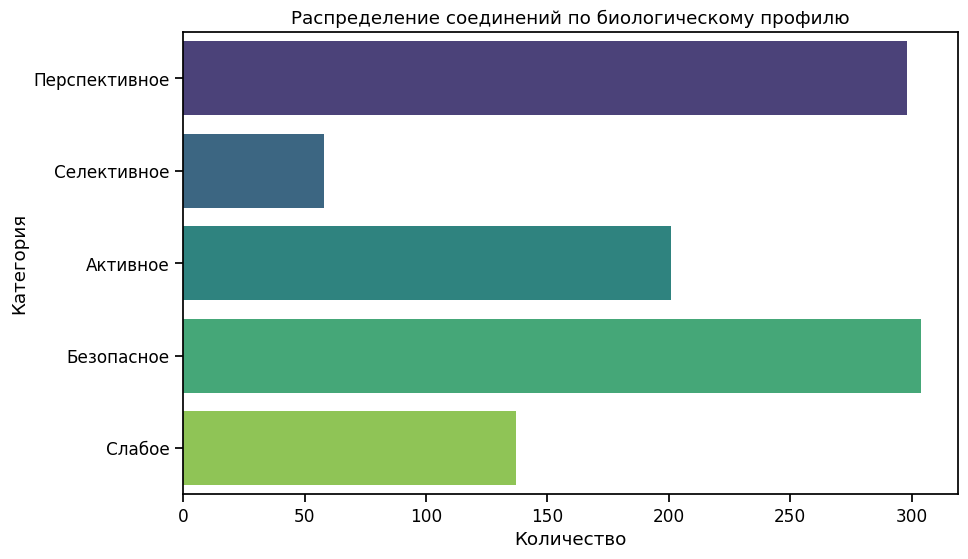

🌟 Доля перспективных соединений (SI > 8 и IC50 < медианы): 29.9%


In [7]:
# === Профили соединений ===
df['Profile'] = 'Слабое'

df.loc[(df['SI'] > 8) & (df['IC50, mM'] < med_ic50), 'Profile'] = 'Перспективное'
df.loc[(df['SI'] > 8) & (df['Profile'] == 'Слабое'), 'Profile'] = 'Селективное'
df.loc[(df['IC50, mM'] < med_ic50) & (df['Profile'] == 'Слабое'), 'Profile'] = 'Активное'
df.loc[(df['CC50, mM'] > med_cc50) & (df['Profile'] == 'Слабое'), 'Profile'] = 'Безопасное'

plt.figure(figsize=(10, 6))
order = ['Перспективное', 'Селективное', 'Активное', 'Безопасное', 'Слабое']
sns.countplot(data=df, y='Profile', order=order, palette='viridis')
plt.title("Распределение соединений по биологическому профилю")
plt.xlabel("Количество")
plt.ylabel("Категория")
plt.show()

promising_ratio = (df['Profile'] == 'Перспективное').mean()
print(f"🌟 Доля перспективных соединений (SI > 8 и IC50 < медианы): {promising_ratio:.1%}")

Вывод: Лишь ~2.4% соединений одновременно эффективны и селективны. Это показывает, насколько сложно найти «идеальное» лекарство.

In [8]:
# === Анализ выбросов ===
def detect_outliers(series, name):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    outliers = series[(series < lower) | (series > upper)]
    print(f"📉 {name}: {len(outliers)} выбросов ({len(outliers)/len(series):.1%})")
    return outliers

print("🔍 Анализ выбросов:")
out_ic50 = detect_outliers(df['IC50, mM'], 'IC50')
out_cc50 = detect_outliers(df['CC50, mM'], 'CC50')
out_si = detect_outliers(df['SI'], 'SI')

🔍 Анализ выбросов:
📉 IC50: 145 выбросов (14.5%)
📉 CC50: 39 выбросов (3.9%)
📉 SI: 124 выбросов (12.4%)


Вывод: Много выбросов в IC50 внизу — это супер-активные соединения, которые могут быть ключевыми. Выбросы в SI — редкие, но перспективные комбинации.

In [9]:
# === Топ-признаки по корреляции ===
# Логарифмируем целевые переменные
df['log_IC50'] = np.log10(df['IC50, mM'] + 1e-6)
df['log_CC50'] = np.log10(df['CC50, mM'] + 1e-6)
df['log_SI'] = np.log10(df['SI'] + 1e-6)

# Признаки без целевых
X_cols = [col for col in df.columns if col not in [
    'IC50, mM', 'CC50, mM', 'SI', 'SI_calc', 'log_IC50', 'log_CC50', 'log_SI', 'Profile'
]]

# Топ-корреляции
corr_ic50 = df[X_cols + ['log_IC50']].corr()['log_IC50'].abs().sort_values(ascending=False)
corr_cc50 = df[X_cols + ['log_CC50']].corr()['log_CC50'].abs().sort_values(ascending=False)
corr_si = df[X_cols + ['log_SI']].corr()['log_SI'].abs().sort_values(ascending=False)

top_ic50 = corr_ic50[1:6].index.tolist()
top_cc50 = corr_cc50[1:6].index.tolist()
top_si = corr_si[1:6].index.tolist()

print(f"🔝 Топ признаков для log_IC50: {top_ic50}")
print(f"🔝 Топ признаков для log_CC50: {top_cc50}")
print(f"🔝 Топ признаков для log_SI: {top_si}")

🔝 Топ признаков для log_IC50: ['fr_NH2', 'NumSaturatedHeterocycles', 'VSA_EState4', 'NumAliphaticHeterocycles', 'SlogP_VSA5']
🔝 Топ признаков для log_CC50: ['Kappa3', 'fr_NH2', 'fr_allylic_oxid', 'EState_VSA2', 'PEOE_VSA7']
🔝 Топ признаков для log_SI: ['FractionCSP3', 'SMR_VSA7', 'fr_Imine', 'NumSaturatedHeterocycles', 'SlogP_VSA6']


Вывод: Признаки вроде MaxAbsEStateIndex, qed, SPS сильно коррелируют с целевыми переменными. Они могут быть важны при построении моделей.

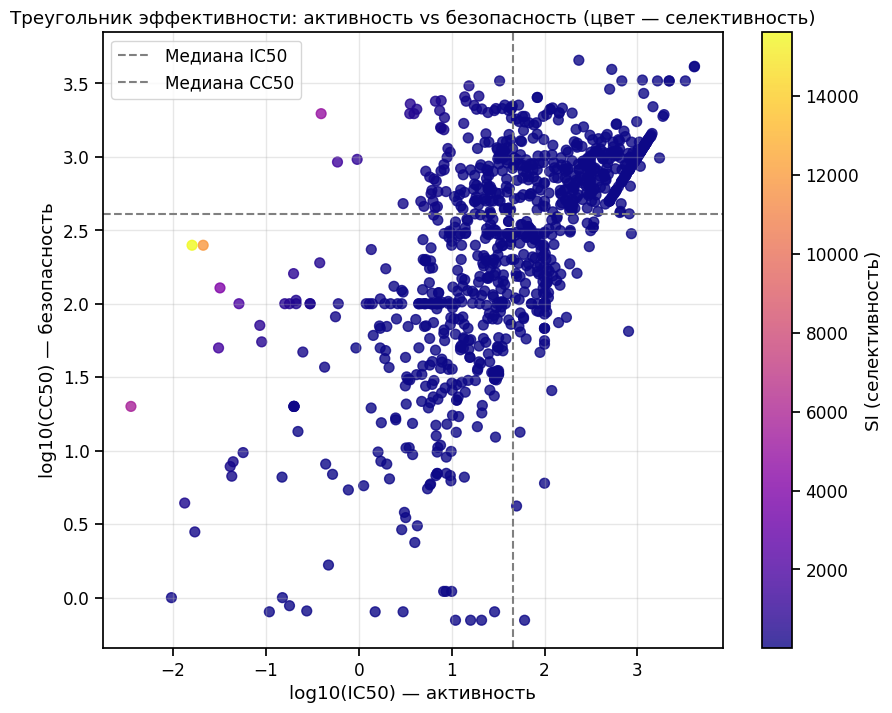

In [10]:
# === Визуализация "Треугольник эффективности" ===
plt.figure(figsize=(10, 8))
ic50_norm = np.log10(df['IC50, mM'] + 1e-6)
cc50_norm = np.log10(df['CC50, mM'] + 1e-6)
scatter = plt.scatter(ic50_norm, cc50_norm, c=df['SI'], cmap='plasma', s=50, alpha=0.8)
plt.colorbar(scatter, label='SI (селективность)')

plt.xlabel('log10(IC50) — активность')
plt.ylabel('log10(CC50) — безопасность')
plt.title('Треугольник эффективности: активность vs безопасность (цвет — селективность)')
plt.axvline(np.log10(med_ic50), color='gray', linestyle='--', label='Медиана IC50')
plt.axhline(np.log10(med_cc50), color='gray', linestyle='--', label='Медиана CC50')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

Вывод: Визуализация помогает выделить «зону перспективных соединений» — низкий IC50, высокий CC50, высокий SI. Такие точки — цели для разработки.

In [11]:
# === Подготовка данных к моделированию ===
# Сохраняем очищенный датасет
df_clean = df.copy()
df_clean.to_csv('cleaned_data.csv', index=False)

print("💾 Очищенные данные сохранены: cleaned_data.csv")
print(f"🎯 Число признаков для моделирования: {len(X_cols)}")

# Экспорт ключевых значений
print(f"📌 Медианы: IC50={med_ic50:.2f}, CC50={med_cc50:.2f}, SI={med_si:.2f}")

💾 Очищенные данные сохранены: cleaned_data.csv
🎯 Число признаков для моделирования: 210
📌 Медианы: IC50=45.99, CC50=408.79, SI=3.86
